# Normal Mode Analysis

Objectives
- use Normal Mode Analysis to extract dynamics features

Resources
- Original code from https://github.com/ShenLab/SeqDance/blob/main/data_prepare/normal_mode_analysis/NMA_features.py
- ProDy tutorials: 
    - http://www.bahargroup.org/prody/tutorials/
    - http://www.bahargroup.org/prody/tutorials/enm_analysis/

In [10]:
from prody import *
from pylab import *
import numpy as np
import sys, getopt

In [11]:
# Define a custom gamma function to modify the force constant based on their distance.
# Higher gamma values indicate stiffer connections, meaning the two atoms move less 
# independently.

def gammaDistanceDependent(dist2, *args):
    """Return a force constant based on the square distance."""
    if dist2 <= 16:
        return 10
    elif dist2 <= 100:
        return 2
    elif dist2 <= 225:
        return 1
    else:
        return 0

In [12]:
# Classify normal modes into three distinct ranges, each contributing to different dynamics
# The function splits the eigenvalues into ranges that account for 33%, 33-66%, and 66-100% 
# of the total dynamic contribution
def get_three_range_from_eigenvalues(eval):
    # Calculate the fractional contribution of each mode to the overall dynamics 
    # (the contribution is inversely proportional to the eigenvalues)
    contri = (1 / eval) / (1 / eval).sum()
    contri_sum = np.cumsum(contri)

    # Identify mode ranges: 0-33%, 33-66%, and 66-100% of the dynamic contribution
    index_1 = np.argmin(np.abs(contri_sum - 1/3))  # Mode contributing up to 33%
    index_2 = np.argmin(np.abs(contri_sum - 0.5 * (1 + contri_sum[index_1])))  # Adjust for large initial contributions

    mode_ranges = [np.arange(index_1 + 1), np.arange(index_1 + 1, index_2 + 1), np.arange(index_2 + 1, len(eval))]
    return mode_ranges

In [13]:
# Calculate mean square fluctuations (MSFs) and pairwise correlations from eigenvectors and eigenvalues
# MSFs capture residue-level movements, and pairwise correlations reveal how residues move together
def get_msf_and_cor_from_3N_eigen(mode_ranges, evec, eval, N):
    msfs = []  # Store mean square fluctuations for each mode range
    cors = []  # Store correlation matrices for each mode range
    for mode_range in mode_ranges:
        # Normalize eigenvectors to account for the contribution of eigenvalues
        evec_normalize = evec[:, mode_range] / np.sqrt(eval[mode_range])

        # Covariance matrix for all x, y, z coordinates of the Cα atoms
        cov_3n = np.dot(evec_normalize, evec_normalize.T)

        # Reduce the 3Nx3N covariance matrix to NxN by taking the trace (summed over x, y, z axes)
        cov_n = np.trace(cov_3n.reshape((N, 3, N, 3)), axis1=1, axis2=3)

        # Diagonal elements of cov_n give the mean square fluctuations for each residue
        msf = np.diag(cov_n)

        # Normalize the covariance matrix by MSFs to obtain a residue correlation map
        cor_n = cov_n / np.sqrt(np.outer(msf, msf))

        msfs.append(msf)
        cors.append(cor_n)
    return msfs, cors

In [14]:
# Calculate MSFs using the Gaussian Network Model (GNM), which provides isotropic dynamics
def calc_gnm_msf(calphas, N):
    # Perform GNM analysis by building the Kirchhoff matrix
    gnm = GNM('GNM analysis')
    gnm.buildKirchhoff(calphas, cutoff=15, gamma=1.0)
    gnm.calcModes(N)
    eval = gnm.getEigvals()
    evec = gnm.getEigvecs()

    # Get MSFs for each of the three dynamic ranges
    mode_ranges = get_three_range_from_eigenvalues(eval)
    
    # Calculate MSFs for each normal mode range
    gnm_msf = []
    for mode_range in mode_ranges:
        gnm_msf.append(((evec[:, mode_range] * evec[:, mode_range]) / eval[mode_range]).sum(axis=1))
    return np.array(gnm_msf)

In [15]:
def calc_anm_cor(calphas, N):
    # Perform ANM analysis by building the Hessian matrix
    anm = ANM('ANM analysis')
    anm.buildHessian(calphas, cutoff=15, gamma=gammaDistanceDependent)
    anm.calcModes(N * 3)
    eval = anm.getEigvals()
    evec = anm.getEigvecs()

    # Get correlation maps for each of the three dynamic ranges
    mode_ranges = get_three_range_from_eigenvalues(eval)
    
    # Calculate MSFs and correlation maps for each normal mode range
    anm_msf, anm_cor = get_msf_and_cor_from_3N_eigen(mode_ranges, evec, eval, N)
    return np.array(anm_cor)

### Experiments

In [9]:
protein = parsePDB('inputs/6FUD.relax.pdb')
calphas = protein.select('calpha')
N = len(calphas)
N

@> 2472 atoms and 1 coordinate set(s) were parsed in 0.01s.


158

In [10]:
gnm_msf = calc_gnm_msf(calphas, N)

@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.04s.


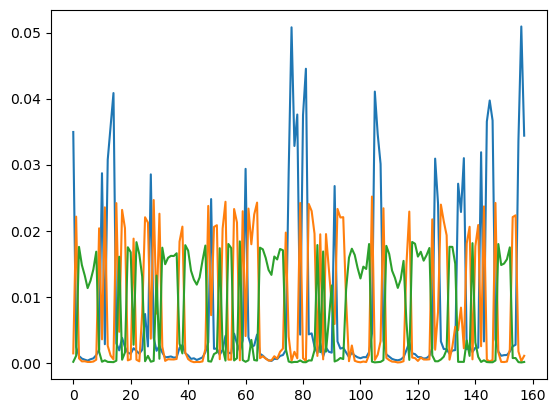

In [30]:
import matplotlib.pyplot as plt

resnum = list(range(0,158))

for i in range(3):
    plt.plot(resnum, gnm_msf[i])

In [18]:
anm_cor = calc_anm_cor(calphas, N)

@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


In [ ]:
anm_cor[0].shape

(158,)

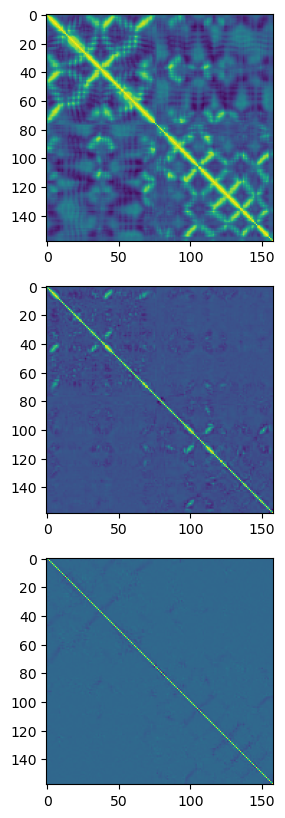

In [34]:
plt.figure(figsize=(7,10))
for i in range(0,3):
    plt.subplot(3,1,i+1)
    plt.imshow(anm_cor[i])

In [36]:
from pathlib import Path
output_dir = Path('nma/')
output_dir.mkdir(parents=True, exist_ok=True)
np.savez_compressed(str(output_dir / ('wt' + '.npz')), gnm_msf=gnm_msf, anm_cor=anm_cor)

### Functionalize

In [16]:
from pathlib import Path
from typing import Union
# functionalize a full run on a given mutant pdb
def run_normal_mode_analysis(pdb_path: Union[str, Path], output_path: Union[str, Path]):
    protein = parsePDB(str(pdb_path))
    calphas = protein.select('calpha')
    N = len(calphas)

    gnm_msf = calc_gnm_msf(calphas, N)
    anm_cor = calc_anm_cor(calphas, N)

    np.savez_compressed(str(output_path), gnm_msf=gnm_msf, anm_cor=anm_cor)

In [17]:
from timeit import default_timer

# Run on NMA on directory and record times
def run_nma_on_dir(input_dir: Union[str, Path], output_dir: Union[str, Path]):
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    pdb_files = list(input_dir.glob('*.pdb'))

    nma_times = []

    for pdb in pdb_files:
        output_path = output_dir / (pdb.stem + '.npz')
        start_time = default_timer()
        run_normal_mode_analysis(pdb, output_path)
        nma_time = default_timer()-start_time
        print(f'Time taken: {nma_time}')
        nma_times.append(nma_time)
    
    total_time = sum(nma_times)
    avg_time = total_time / len(pdb_files)
    print(f'Total time: {total_time}')
    print(f'Average time per mutant: {avg_time}')

In [18]:
run_nma_on_dir('mutant_library', 'nma')

@> 2445 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.02s.
@> 157 modes were calculated in 0.02s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2462 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2449 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.16255010000168113
Time taken: 0.0952055570014636
Time taken: 0.0971047390048625


@> 2498 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2476 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.01s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2477 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11008975800359622
Time taken: 0.09126245100196684
Time taken: 0.10514639299799455


@> 2482 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2501 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2476 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11127685899555217
Time taken: 0.0977415059969644
Time taken: 0.10236469100345857


@> 2495 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2487 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.02s.
@> 468 modes were calculated in 0.02s.
@> 2469 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.02s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10130531200411497
Time taken: 0.0978955649989075
Time taken: 0.09455996500037145


@> 2469 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2467 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2469 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10540873600257328
Time taken: 0.10825723900052253


@> 2451 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2477 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11578516999725252
Time taken: 0.09531195900490275


@> 2496 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2456 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.02s.
@> 468 modes were calculated in 0.02s.
@> 2474 atoms and 1 coordinate set(s) were parsed in 0.01s.


Time taken: 0.10882253599993419
Time taken: 0.10314903199468972
Time taken: 0.08418487200106028


@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2470 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2465 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.09264164000342134
Time taken: 0.10561537399917142
Time taken: 0.08867241400002968


@> 2482 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2480 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2485 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11111499300022842
Time taken: 0.10884612700465368


@> 2480 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2463 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11854704699362628
Time taken: 0.09896940599719528


@> 2486 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2476 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11362034500052687
Time taken: 0.10856795700237853


@> 2473 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2451 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10351102899585385
Time taken: 0.11498832800134551


@> 2472 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2462 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11979954499838641
Time taken: 0.11663269400014542


@> 2487 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2468 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10258553300081985
Time taken: 0.11995762800506782


@> 2470 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2460 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.1108926419983618
Time taken: 0.11642850100179203


@> 2489 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2480 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11001082100119675
Time taken: 0.09817820099851815


@> 2475 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2471 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.02s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11231305899855215
Time taken: 0.11128835999988951


@> 2482 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.02s.
@> 468 modes were calculated in 0.02s.
@> 2467 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.09218152399989776
Time taken: 0.09692377199826296
Time taken: 0.10125194600550458


@> 2487 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2439 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2484 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.02s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.0974549759994261
Time taken: 0.10237534799671266
Time taken: 0.09400505400117254


@> 2491 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.03s.
@> 2458 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2462 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.02s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11496859500039136
Time taken: 0.10914536200289149
Time taken: 0.08823493299860274


@> 2477 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2479 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2467 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.09328469100000802
Time taken: 0.1084092880046228


@> 2485 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2490 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.09984899099799804
Time taken: 0.11394219900103053


@> 2449 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2472 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11923642300098436
Time taken: 0.12079311800334835


@> 2448 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.02s.
@> 468 modes were calculated in 0.02s.
@> 2464 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10831238299579127
Time taken: 0.09412268699816195


@> 2468 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2449 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11525169800006552
Time taken: 0.10527703200204996


@> 2485 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2470 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11039595599868335
Time taken: 0.0993079879990546


@> 2493 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2471 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11487370100076078
Time taken: 0.11453111200535204


@> 2480 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2482 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10327799199876608
Time taken: 0.11001017400121782


@> 2470 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.02s.
@> 468 modes were calculated in 0.02s.
@> 2477 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.01s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.09574708800209919
Time taken: 0.09734159299841849


@> 2471 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2481 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.1127328380025574
Time taken: 0.11914825699932408


@> 2495 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2480 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10164952000195626
Time taken: 0.10170341299817665


@> 2469 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2479 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11991884699818911
Time taken: 0.12318979799601948


@> 2476 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2479 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.09438938599487301
Time taken: 0.10797261400148273


@> 2472 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2487 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.09713322699826676
Time taken: 0.11260171899630222


@> 2482 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2471 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11107981100212783
Time taken: 0.1109389090051991


@> 2475 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2480 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10786773500149138
Time taken: 0.11859131699748104


@> 2482 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2467 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.09928089699678821
Time taken: 0.11376751300122123


@> 2505 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2460 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.02s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10138622899830807
Time taken: 0.10618530600186205


@> 2480 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2464 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.09703763099969365
Time taken: 0.09662588199716993
Time taken: 0.09282963700388791


@> 2476 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2467 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2475 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.09850100099720294
Time taken: 0.10801631499634823


@> 2469 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2477 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11279505400307244
Time taken: 0.10171043500304222


@> 2475 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2469 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.


Time taken: 0.10305884899571538
Time taken: 0.12946403100067982


@> 468 modes were calculated in 0.02s.
@> 2471 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2468 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.12400448699918343
Time taken: 0.11668057800125098


@> 2461 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2462 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10942255199915962
Time taken: 0.10479532700264826


@> 2468 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2455 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.1063664319954114
Time taken: 0.10779737700067926


@> 2477 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.02s.
@> 468 modes were calculated in 0.02s.
@> 2460 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.1038442689969088
Time taken: 0.0935796539997682
Time taken: 0.09507690199825447


@> 2473 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2439 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2486 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10051685199869098
Time taken: 0.11547702100506285


@> 2468 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2467 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.0950833099996089
Time taken: 0.10629187699669274


@> 2490 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2456 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11044049000338418
Time taken: 0.10211980900203343


@> 2475 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2457 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.1116242179996334
Time taken: 0.1015632380003808


@> 2462 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2466 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.12261976599984337
Time taken: 0.10773502699885285


@> 2469 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2468 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10819124100089539
Time taken: 0.10371513000427512


@> 2464 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2463 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11951204000069993
Time taken: 0.11184537900408031


@> 2494 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2483 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.09734548500273377
Time taken: 0.1034666310006287


@> 2475 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2489 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10612046199821634
Time taken: 0.11736482899868861


@> 2477 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.02s.
@> 468 modes were calculated in 0.03s.
@> 2469 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11122239100222941
Time taken: 0.10146161100419704


@> 2486 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2488 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11223122899536975
Time taken: 0.11013976099638967


@> 2466 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2469 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11960362199897645
Time taken: 0.09744483399845194


@> 2469 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2480 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.1088602770032594
Time taken: 0.09828783800185192
Time taken: 0.09727907400520053


@> 2488 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2454 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2469 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.09625979400152573
Time taken: 0.11202258200501092


@> 2483 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2480 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.1053319639977417
Time taken: 0.11069980100000976


@> 2457 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.02s.
@> 468 modes were calculated in 0.02s.
@> 2477 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11670720000256551
Time taken: 0.10696000399912009


@> 2472 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2480 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.09622235199640272
Time taken: 0.09609273400565144
Time taken: 0.10106209699733881


@> 2485 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2479 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2458 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10392545200011227
Time taken: 0.09934420599893201


@> 2486 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2455 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.


Time taken: 0.11392562599939993
Time taken: 0.11536722700111568


@> 468 modes were calculated in 0.02s.
@> 2458 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2460 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.12018218300363515
Time taken: 0.09794391500327038


@> 2479 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2478 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2491 atoms and 1 coordinate set(s) were parsed in 0.01s.


Time taken: 0.10754566700052237
Time taken: 0.09359563600446563
Time taken: 0.0920015779993264


@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2449 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2477 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.02s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10753972900420194
Time taken: 0.10949250900011975
Time taken: 0.08998529399832478


@> 2473 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2468 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2460 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.1087986640050076
Time taken: 0.10967218199948547


@> 2481 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2472 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10669327899813652
Time taken: 0.10034666099818423


@> 2468 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2470 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.02s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11137437500292435
Time taken: 0.10610401799931424


@> 2475 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2460 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10429254799964838
Time taken: 0.11289574700640514


@> 2487 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2471 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.


Time taken: 0.09369050899840659
Time taken: 0.12482777800323674


@> 468 modes were calculated in 0.02s.
@> 2468 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2458 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10063439100485994
Time taken: 0.11210163800569717


@> 2487 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.01s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2478 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.09235830399848055
Time taken: 0.12258339099935256


@> 2479 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2469 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.09368287600227632
Time taken: 0.10429487700457685


@> 2455 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2484 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10101611300342483
Time taken: 0.11365225700137671


@> 2470 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2485 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10571591500047361
Time taken: 0.10042013999918709


@> 2465 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2462 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11537233600392938
Time taken: 0.09725772000092547
Time taken: 0.0971324350030045


@> 2474 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2476 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2458 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11175983199791517
Time taken: 0.10687872400012566


@> 2463 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2474 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10691428899735911
Time taken: 0.11884379600087414


@> 2459 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2475 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10443705299985595
Time taken: 0.10181078699679347


@> 2478 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2481 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.12174731199775124
Time taken: 0.11364077400503447


@> 2464 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2462 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10999669699958758
Time taken: 0.10929546000261325


@> 2480 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2466 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11004475600202568
Time taken: 0.09263418200134765
Time taken: 0.10471838500234298


@> 2491 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2456 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2481 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10858792700310005
Time taken: 0.09838217399374116
Time taken: 0.0929708199982997


@> 2467 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2483 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2461 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10709428800328169
Time taken: 0.1145868320018053


@> 2469 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2454 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in -1.54s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11475102600525133
Time taken: 0.1151900279946858


@> 2475 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2482 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10429537399613764
Time taken: 0.11380382999777794


@> 2455 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2490 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10556554300274001
Time taken: 0.10971013399830554


@> 2501 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2475 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.02s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10806498699821532
Time taken: 0.11734477800200693


@> 2487 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2487 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.09232315800181823
Time taken: 0.1062841889943229


@> 2465 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2458 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.1031046390053234
Time taken: 0.09647282499645371


@> 2476 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2476 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.01s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11778257300466066
Time taken: 0.11251002099743346


@> 2488 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2479 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11545868400571635
Time taken: 0.10966913900483632


@> 2496 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2489 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.1016967250034213
Time taken: 0.10261277300014626


@> 2468 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2460 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.


Time taken: 0.1022426319977967
Time taken: 0.1266684139991412


@> 468 modes were calculated in 0.02s.
@> 2496 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2473 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10450588600360788
Time taken: 0.11555226899508853


@> 2489 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2480 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10736232800263679
Time taken: 0.11773812200408429


@> 2456 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.01s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2467 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.05s.


Time taken: 0.11490637699898798
Time taken: 0.13194160100101726


@> 468 modes were calculated in 0.02s.
@> 2493 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.05s.
@> 468 modes were calculated in 0.02s.
@> 2469 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.12797939700249117
Time taken: 0.11570654699607985


@> 2474 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2467 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.0968015460020979
Time taken: 0.10983033900265582


@> 2488 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.03s.
@> 2479 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10716579399741022
Time taken: 0.11539534799521789


@> 2455 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.02s.
@> 468 modes were calculated in 0.02s.
@> 2477 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10853902300004847
Time taken: 0.09438580500136595


@> 2471 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2476 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10972716299875174
Time taken: 0.11891934400046011


@> 2448 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2464 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.1060744540009182
Time taken: 0.09994249200099148


@> 2479 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2476 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.12199493599473499
Time taken: 0.1077809230046114


@> 2488 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2453 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11319513399939751
Time taken: 0.10991640800057212


@> 2477 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2457 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10434899600659264
Time taken: 0.1044649629984633


@> 2486 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2470 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11786276500060922
Time taken: 0.10158889900048962


@> 2453 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.05s.
@> 468 modes were calculated in 0.03s.
@> 2477 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.


Time taken: 0.1200760059946333
Time taken: 0.13056842600053642


@> 468 modes were calculated in 0.02s.
@> 2477 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2482 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11109575600130484
Time taken: 0.11004611600219505


@> 2467 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2468 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11627984100050526
Time taken: 0.11062953399959952


@> 2499 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2485 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10554553999827476
Time taken: 0.10214853299839888
Time taken: 0.09752736399968853


@> 2469 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2478 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2465 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.12454756800434552
Time taken: 0.10415374700096436


@> 2469 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2448 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11509986400051275
Time taken: 0.10113643200020306


@> 2478 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2473 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10377966400119476
Time taken: 0.10641352000675397


@> 2474 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2483 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11467840299883392
Time taken: 0.11515244300244376


@> 2444 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2474 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.10816374199930578
Time taken: 0.10380600600183243
Time taken: 0.09749346999888076


@> 2466 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2473 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2476 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.117032501999347
Time taken: 0.10657542999979341


@> 2473 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.05s.
@> 468 modes were calculated in 0.02s.
@> 2485 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.


Time taken: 0.10071175099437824
Time taken: 0.13820518500142498


@> 468 modes were calculated in 0.02s.
@> 2483 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.04s.
@> 2464 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.00s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.


Time taken: 0.11707607100106543
Time taken: 0.1441037340046023


@> 468 modes were calculated in 0.02s.
@> 2471 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2485 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.1201065809946158
Time taken: 0.11643474599986803


@> 2472 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2480 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11538717700022971
Time taken: 0.1206621500023175


@> 2460 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.05s.
@> 468 modes were calculated in 0.02s.
@> 2500 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.


Time taken: 0.09833943199919304
Time taken: 0.14914186999521917


@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.03s.
@> 2469 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2489 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.11802331699436763
Time taken: 0.1013631469977554


@> 2497 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.03s.
@> 2462 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.


Time taken: 0.12084323599992786
Time taken: 0.1255376109984354


@> 468 modes were calculated in 0.02s.
@> 2456 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2473 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.


Time taken: 0.11716153499583015
Time taken: 0.13034093099849997


@> 468 modes were calculated in 0.02s.
@> 2497 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.03s.
@> 2469 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.


Time taken: 0.11701078699843492
Time taken: 0.12294509999628644


@> 468 modes were calculated in 0.02s.
@> 2473 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2484 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.


Time taken: 0.12960622199898353
Time taken: 0.12971069299965166


@> 468 modes were calculated in 0.02s.
@> 2454 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2457 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.03s.


Time taken: 0.13320682500489056
Time taken: 0.10709306500211824


@> 2487 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2456 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.05s.


Time taken: 0.12416275799478171
Time taken: 0.11584878799476428


@> 468 modes were calculated in 0.02s.
@> 2468 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2450 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.12512316399806878
Time taken: 0.11227264100307366


@> 2465 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2487 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.


Time taken: 0.11228029600169975
Time taken: 0.1342887890059501


@> 468 modes were calculated in 0.02s.
@> 2479 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.03s.
@> 2474 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.


Time taken: 0.12906316500448156
Time taken: 0.1468919039980392


@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2477 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2457 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.


Time taken: 0.12359446700429544
Time taken: 0.12194901600014418


@> 468 modes were calculated in 0.02s.
@> 2452 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.03s.
@> 2456 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.


Time taken: 0.11935998300032225
Time taken: 0.14720672099792864


@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2487 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.
@> 2471 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.14070499499939615
Time taken: 0.10852660200180253


@> 2455 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2470 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.


Time taken: 0.11841659899801016
Time taken: 0.14016155900026206


@> Hessian was built in 0.04s.
@> 468 modes were calculated in 0.02s.
@> 2464 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Kirchhoff was built in 0.01s.
@> 157 modes were calculated in 0.00s.
@> Hessian was built in 0.03s.
@> 468 modes were calculated in 0.02s.


Time taken: 0.1266172559990082
Time taken: 0.10707758200442186
Total time: 32.818972380096966
Average time per mutant: 0.10939657460032322
